# Initiation

In [2]:
%matplotlib inline
from datetime import timedelta

import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge

from GeneralRegression.GeneralRegression import GenericRegressor
from GeneralRegression.NpyProximation import HilbertRegressor, Measure
from GeneralRegression.extras import FunctionBasis


# Fourier base generator
def mixed(X, p_d=3, f_d=1, l=1., e_d=2):
    points = []
    for x in X:
        point = []
        point.append(1.)
        for deg in range(1, f_d + 1):
            point.append(np.sin(deg * x[0] / l))
            point.append(np.cos(deg * x[0] / l))
        for deg in range(1, p_d + 1):
            point.append(x[0] ** deg)
        for deg in range(e_d + 1):
            point.append((x[0] ** deg) * np.exp(-x[0] / l))
            point.append((x[0] ** deg) * np.exp(x[0] / (2.5 * l)))
        points.append(np.array(point))
    return np.array(points)

def pfe_1d(p_d=3, f_d=1, l=1., e_d=2):
    basis = FunctionBasis()
    p_basis = basis.poly(1, p_d)
    f_basis = basis.fourier(1, f_d, l)[1:]
    e_basis = []
    # for d in range(e_d + 1):
    # e_basis.append(lambda x: (x ** d) * np.exp(-x / l))
    # e_basis.append(lambda x: (x ** d) * np.exp(x / (2.5 * l)))
    return p_basis + f_basis + e_basis

def aggregate(df, method='monthly'):
    from pandas import DataFrame
    new_df = DataFrame()
    min_date = min(df['date'])
    max_date = max(df['date'])
    cur_date = min_date
    clmns = list(df.columns)
    clmns.pop(clmns.index('date'))
    idx = 0.
    while cur_date < max_date:
        nxt_date = cur_date
        if method == 'daily':
            nxt_date = cur_date + timedelta(days=1)
            stp = .01
        elif method == 'monthly':
            stp = .1
            nxt_date = cur_date + timedelta(days=31)
            nxt_date = nxt_date - timedelta(days=(nxt_date.day - 1))
        t_df = df[(df['date'] >= cur_date) & (df['date'] < nxt_date)].mean()
        dct = {clmn: [t_df[clmn]] for clmn in clmns}
        dct['date'] = [cur_date]
        dct['t'] = idx
        row = DataFrame(dct)
        new_df = new_df.append(row, ignore_index=True)
        cur_date = nxt_date
        idx += stp
    return new_df

def plot_population(df, center='Regina', yrs=2, start=5., method='daily'):
    import matplotlib.pyplot as plt
    from random import randint
    plt.figure(randint(1, 1000), figsize=(16, 12))
    ell = 20
    time_span = 1.2
    if method == 'daily':
        time_span = 3.65
        ell = 20
    elif method == 'monthly':
        time_span = 1.2
        ell = 4
    c_df = aggregate(df, method=method)
    x = c_df['t'].values
    y_s = c_df['SEN_%s' % center].values
    y_r = c_df['REM_%s' % center].values
    x_t = x.reshape(-1, 1)
    y_ts = y_s  # .reshape(-1, 1)
    y_tr = y_r  # .reshape(-1, 1)
    x_f = np.linspace(start, max(x) + yrs * time_span, 200)
    model1 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=1, f_d=50, l=ell, e_d=0))
    model1.fit(x_t, y_ts)
    plt.scatter(x, y_ts, color='black', s=1, marker='o', alpha=0.2)  # , label="Sentenced actual counts")
    y_ps = model1.predict(x_f.reshape(-1, 1))
    plt.plot(x_f, y_ps, color='lightgreen', linewidth=1, label="Sentenced")
    plt.fill_between(x_f,
                     y_ps - model1.ci_band,
                     y_ps + model1.ci_band,
                     color='lightgreen',
                     alpha=0.1)
    model2 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=1, f_d=30, l=5, e_d=0))
    model2.fit(x_t, y_tr)
    plt.scatter(x, y_tr, color='black', s=1, marker='o', alpha=0.2)  # , label="Remand  actual counts")
    y_pr = model2.predict(x_f.reshape(-1, 1))
    plt.plot(x_f, y_pr, color='blue', linewidth=1, label="Remand")
    plt.fill_between(x_f,
                     y_pr - model2.ci_band,
                     y_pr + model2.ci_band,
                     color='blue',
                     alpha=0.1)
    # model3 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=2, f_d=2, l=3., e_d=0))
    # model3.fit(x_t, (y_tr + y_ts))
    plt.scatter(x, (y_tr + y_ts), color='black', s=1, marker='o', alpha=0.2)  # , label="Total custody counts")
    # y_prs = model3.predict(x_f.reshape(-1, 1))
    plt.plot(x_f, y_pr + y_ps, color='red', linewidth=1, label="Total")
    plt.fill_between(x_f,
                     y_pr + y_ps - (model1.ci_band + model2.ci_band) / 2.,
                     y_pr + y_ps + (model1.ci_band + model2.ci_band) / 2.,
                     color='red',
                     alpha=0.1)
    plt.title(center)
    plt.legend(loc=2)
    plt.grid(True, linestyle='-.', alpha=.2)
    plt.savefig(center + '.png', dpi=200)
    return plt


def plot_population_hilbert(df, center='Regina', yrs=2, start=5., method='daily'):
    import matplotlib.pyplot as plt
    from random import randint
    #plt.figure(randint(1, 1000), figsize=(16, 12))
    fig = plt.figure(randint(1, 10000), constrained_layout=True, figsize=(14, 12))
    gs = fig.add_gridspec(4, 1)
    f_ax1 = fig.add_subplot(gs[:3, :])
    ell = 20
    time_span = 1.2
    if method == 'daily':
        time_span = 3.65
        ell = 20
    elif method == 'monthly':
        time_span = 1.2
        ell = 4
    c_df = aggregate(df, method=method)
    x = c_df['t'].values
    y_s = c_df['SEN_%s' % center].values
    y_r = c_df['REM_%s' % center].values
    x_t = x.reshape(-1, 1)
    y_ts = y_s  # .reshape(-1, 1)
    y_tr = y_r  # .reshape(-1, 1)
    x_f = np.linspace(start, max(x) + yrs * time_span, 200)
    # model1 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=1, f_d=50, l=ell, e_d=0))
    x_min, x_max = x_t.min(), x_t.max()
    x_mid = (x_min + x_max) / 2.
    w_min = .1
    w_max = 5.
    ws = {_[0]:
          # w_min + (w_max - w_min) * (_[0] - x_min) / (x_max - x_min)  # if _[0]<.8 * x_max else 10.
          .1 if _[0] < 1.5 * x_mid else 1.
          # 1. / (1. + np.exp(-(_[0] - 4. * x_mid / 5.)))
          # np.exp(-(_[0] - x_max) ** 2 / ((_[0] - x_min) ** 2 + 1.))
          for _ in x_t}
    Xs = [_[0] for _ in x_t]
    Ws = [ws[_] for _ in Xs]
    f_ = lambda x, x_min=x_min, x_max=x_max: np.exp(-(x[0] - x_max) ** 2 / ((x[0] - x_min) ** 2 + 1.e-1))
    meas = Measure(ws)
    B1 = pfe_1d(p_d=1, f_d=20, l=ell, e_d=0)
    model1 = HilbertRegressor(base=B1, meas=meas)
    model1.fit(x_t, y_ts)

    f_ax1.scatter(x, y_ts, color='black', s=1, marker='o', alpha=0.2)  # , label="Sentenced actual counts")
    y_ps = model1.predict(x_f.reshape(-1, 1))
    f_ax1.plot(x_f, y_ps, color='lightgreen', linewidth=1, label="Sentenced")
    f_ax1.fill_between(x_f,
                     y_ps - model1.ci_band,
                     y_ps + model1.ci_band,
                     color='lightgreen',
                     alpha=0.1)
    # model2 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=1, f_d=30, l=5, e_d=0))
    B2 = pfe_1d(p_d=1, f_d=20, l=ell, e_d=0)
    model2 = HilbertRegressor(base=B2, meas=meas)
    model2.fit(x_t, y_tr)
    f_ax1.scatter(x, y_tr, color='black', s=1, marker='o', alpha=0.2)  # , label="Remand  actual counts")
    y_pr = model2.predict(x_f.reshape(-1, 1))
    f_ax1.plot(x_f, y_pr, color='blue', linewidth=1, label="Remand")
    f_ax1.fill_between(x_f,
                     y_pr - model2.ci_band,
                     y_pr + model2.ci_band,
                     color='blue',
                     alpha=0.1)
    # model3 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=2, f_d=2, l=3., e_d=0))
    # model3.fit(x_t, (y_tr + y_ts))
    f_ax1.scatter(x, (y_tr + y_ts), color='black', s=1, marker='o', alpha=0.2)  # , label="Total custody counts")
    # y_prs = model3.predict(x_f.reshape(-1, 1))
    f_ax1.plot(x_f, y_pr + y_ps, color='red', linewidth=1, label="Total")
    f_ax1.fill_between(x_f,
                     y_pr + y_ps - (model1.ci_band + model2.ci_band) / 2.,
                     y_pr + y_ps + (model1.ci_band + model2.ci_band) / 2.,
                     color='red',
                     alpha=0.1)
    f_ax1.set_title(center)
    f_ax1.set_ylabel('Population')
    f_ax1.legend(loc=2)
    f_ax1.grid(True, linestyle='-.', alpha=.2)
    f_ax2 = fig.add_subplot(gs[3, :])
    f_ax2.set_title('Weights')
    f_ax2.bar(Xs, Ws, label='Distibution', color='teal', alpha=.3)
    f_ax2.set_ylabel('Weight')
    f_ax2.set_xlabel('Dates')
    plt.savefig(center + '_hil.png', dpi=200)
    return plt


def plot_population_baseline(df, center='Regina', yrs=2, start=5., method='daily'):
    import matplotlib.pyplot as plt
    from random import randint
    from scipy.misc import derivative
    fig = plt.figure(randint(1, 10000), constrained_layout=True, figsize=(14, 12))
    gs = fig.add_gridspec(7, 1)
    f_ax1 = fig.add_subplot(gs[:3, :])
    ell = 20
    time_span = 1.2
    if method == 'daily':
        time_span = 3.65
        ell = 20
    elif method == 'monthly':
        time_span = 1.2
        ell = 4
    c_df = aggregate(df, method=method)
    sc_df = c_df[c_df['t'] >= start]
    x = sc_df['t'].values
    y_s = sc_df['SEN_%s' % center].values
    y_r = sc_df['REM_%s' % center].values
    x_t = x.reshape(-1, 1)
    y_ts = y_s  # .reshape(-1, 1)
    y_tr = y_r  # .reshape(-1, 1)
    x_f = np.linspace(start, max(x) + yrs * time_span, 200)
    # model1 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=1, f_d=50, l=ell, e_d=0))
    x_min, x_max = x_t.min(), x_t.max()
    x_thrshld = 17. # x_min + 3 * (x_max - x_min) / 4.
    w_min = .1
    w_max = 5.
    ws = {_[0]:
          # w_min + (w_max - w_min) * (_[0] - x_min) / (x_max - x_min)  # if _[0]<.8 * x_max else 10.
              .1 if _[0] < x_thrshld else 1.
          # 1. / (1. + np.exp(-(_[0] - 4. * x_mid / 5.)))
          # np.exp(-(_[0] - x_max) ** 2 / ((_[0] - x_min) ** 2 + 1.))
          for _ in x_t}
    Xs = [_[0] for _ in x_t]
    Ws = [ws[_] for _ in Xs]
    f_ = lambda x, x_min=x_min, x_max=x_max: np.exp(-(x[0] - x_max) ** 2 / ((x[0] - x_min) ** 2 + 1.e-1))
    meas = Measure(ws)
    B1 = pfe_1d(p_d=3, f_d=0, l=ell, e_d=2)
    model1 = HilbertRegressor(base=B1, meas=meas)
    model1.fit(x_t, y_ts)

    f_ax1.scatter(x, y_ts, color='black', s=1, marker='o', alpha=0.2)  # , label="Sentenced actual counts")
    y_ps = model1.predict(x_f.reshape(-1, 1))
    fs = lambda x: derivative(model1.predict, x, .01) / 100.
    f_ax1.plot(x_f, y_ps, color='lightgreen', linewidth=1, label="Sentenced")
    f_ax1.fill_between(x_f,
                       y_ps - model1.ci_band,
                       y_ps + model1.ci_band,
                       color='lightgreen',
                       alpha=0.1)
    # model2 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=1, f_d=30, l=5, e_d=0))
    B2 = pfe_1d(p_d=3, f_d=0, l=ell, e_d=2)
    model2 = HilbertRegressor(base=B2, meas=meas)
    model2.fit(x_t, y_tr)
    f_ax1.scatter(x, y_tr, color='black', s=1, marker='o', alpha=0.2)  # , label="Remand  actual counts")
    y_pr = model2.predict(x_f.reshape(-1, 1))
    fr = lambda x: derivative(model2.predict, x, .01) / 100.
    f_ax1.plot(x_f, y_pr, color='blue', linewidth=1, label="Remand")
    f_ax1.fill_between(x_f,
                       y_pr - model2.ci_band,
                       y_pr + model2.ci_band,
                       color='blue',
                       alpha=0.1)
    # model3 = GenericRegressor(mixed, regressor=BayesianRidge, **dict(p_d=2, f_d=2, l=3., e_d=0))
    # model3.fit(x_t, (y_tr + y_ts))
    f_ax1.scatter(x, (y_tr + y_ts), color='black', s=1, marker='o', alpha=0.2)  # , label="Total custody counts")
    # y_prs = model3.predict(x_f.reshape(-1, 1))
    f_ax1.plot(x_f, y_pr + y_ps, color='red', linewidth=1, label="Total")
    f_ax1.fill_between(x_f,
                       y_pr + y_ps - (model1.ci_band + model2.ci_band) / 2.,
                       y_pr + y_ps + (model1.ci_band + model2.ci_band) / 2.,
                       color='red',
                       alpha=0.1)
    f_ax1.set_title(center)
    f_ax1.set_ylabel('Population')
    f_ax1.legend(loc=2)
    f_ax1.grid(True, linestyle='-.', alpha=.2)
    f_ax2 = fig.add_subplot(gs[3, :])
    f_ax2.set_title('Weights')
    f_ax2.bar(Xs, Ws, label='Distibution', color='teal', alpha=.3)
    f_ax2.set_ylabel('Weight')
    f_ax2.set_xlabel('Dates')
    f_ax3 = fig.add_subplot(gs[4:, :])
    f_ax3.set_title("Growth Rate")
    gs = fs(x_f.reshape(-1, 1))
    gr = fr(x_f.reshape(-1, 1))
    f_ax3.plot(x_f, gs, color='lightgreen', linewidth=1, label="Sentenced")
    f_ax3.plot(x_f, gr, color='blue', linewidth=1, label="Remand")
    f_ax3.plot(x_f, gs + gr, color='red', linewidth=1, label="Total")
    plt.savefig(center + '_base.png', dpi=200)

def prophet(df, center='Regina', yrs=2):
    import matplotlib.pyplot as plt
    from fbprophet import Prophet
    from random import randint
    fig = plt.figure(randint(1, 1000), figsize=(16, 12))
    df1 = df[['date', 'REM_%s' % center]]
    df2 = df[['date', 'SEN_%s' % center]]
    df1.rename(columns={'date': 'ds', 'REM_%s' % center: 'y'}, inplace=True)
    df2.rename(columns={'date': 'ds', 'SEN_%s' % center: 'y'}, inplace=True)
    m1 = Prophet()
    m1.fit(df1)
    m2 = Prophet()
    m2.fit(df2)
    future1 = m1.make_future_dataframe(periods=yrs * 365)
    future2 = m2.make_future_dataframe(periods=yrs * 365)
    forecast1 = m1.predict(future1)
    forecast2 = m2.predict(future2)
    y1 = df1['y'].values
    y1_hat = forecast1['yhat'].values
    y1_l = forecast1['yhat_lower'].values
    y1_u = forecast1['yhat_upper'].values
    plt.scatter(range(y1.shape[0]), y1, color='black', s=1, marker='o', alpha=0.1)
    plt.plot(y1_hat, color='blue', linewidth=1, label='Remand')
    plt.fill_between(range(y1_hat.shape[0]), y1_l, y1_u, color='blue', alpha=0.1)
    y2 = df2['y'].values
    y2_hat = forecast2['yhat'].values
    y2_l = forecast2['yhat_lower'].values
    y2_u = forecast2['yhat_upper'].values
    plt.scatter(range(y2.shape[0]), y2, color='black', s=1, marker='o', alpha=0.1)
    plt.plot(y2_hat, color='lightgreen', linewidth=1, label='Sentenced')
    plt.fill_between(range(y2_hat.shape[0]), y2_l, y2_u, color='lightgreen', alpha=0.1)
    plt.scatter(range(y2.shape[0]), (y1 + y2), color='black', s=1, marker='o', alpha=.1)
    # y_prs = model3.predict(x_f.reshape(-1, 1))
    plt.plot(y1_hat + y2_hat, color='red', linewidth=1, label="Total")
    plt.fill_between(range(y2_hat.shape[0]),
                     (y1_l + y2_l),
                     (y1_u + y2_u),
                     color='red',
                     alpha=0.1)
    plt.title(center)
    plt.legend(loc=2)
    plt.grid(True, linestyle='-.', alpha=.2)
    plt.savefig(center + '_fb.png', dpi=200)
    return plt
    # plt.show()


# Setting up the dataset

In [3]:
df = pd.read_csv("./data/RemandCnt.csv", parse_dates=['date'])
yrs = 5
centers = ['Regina', 'Saskatoon', 'PrinceAlbert', 'PineGrove']


# Unweighted Plots

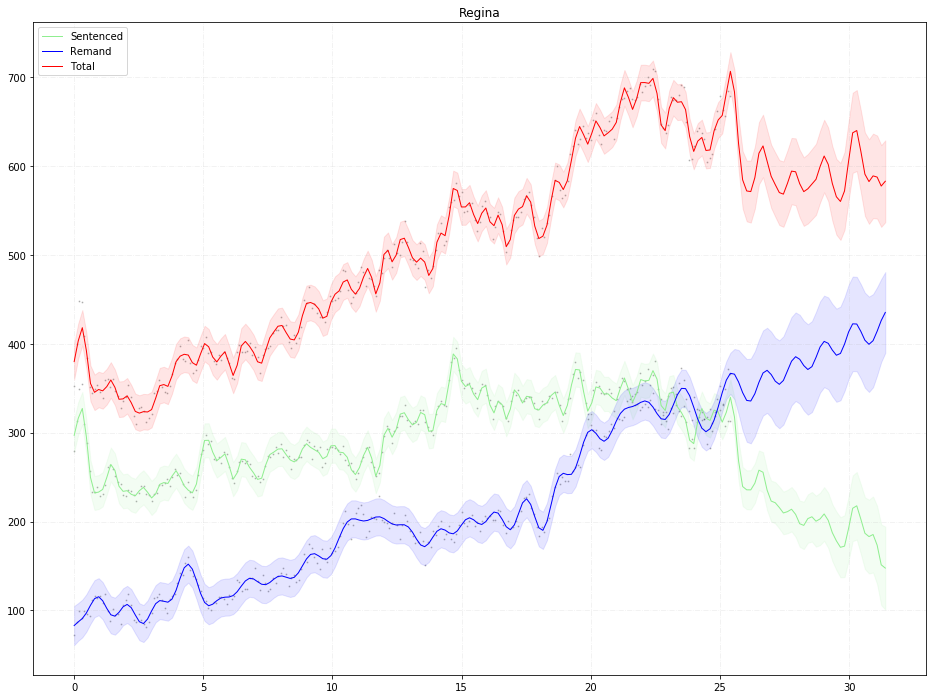

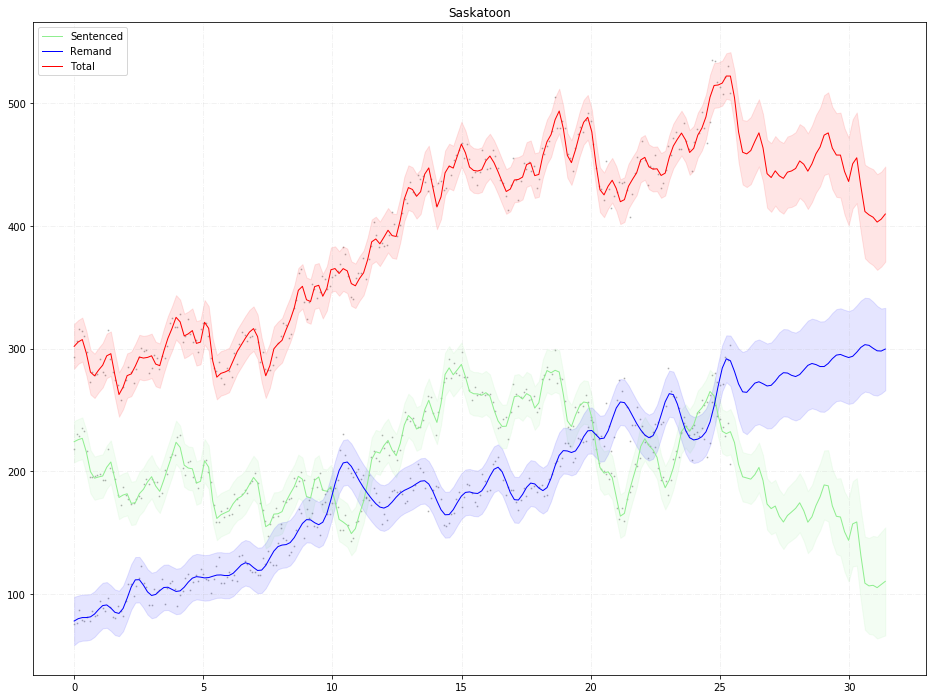

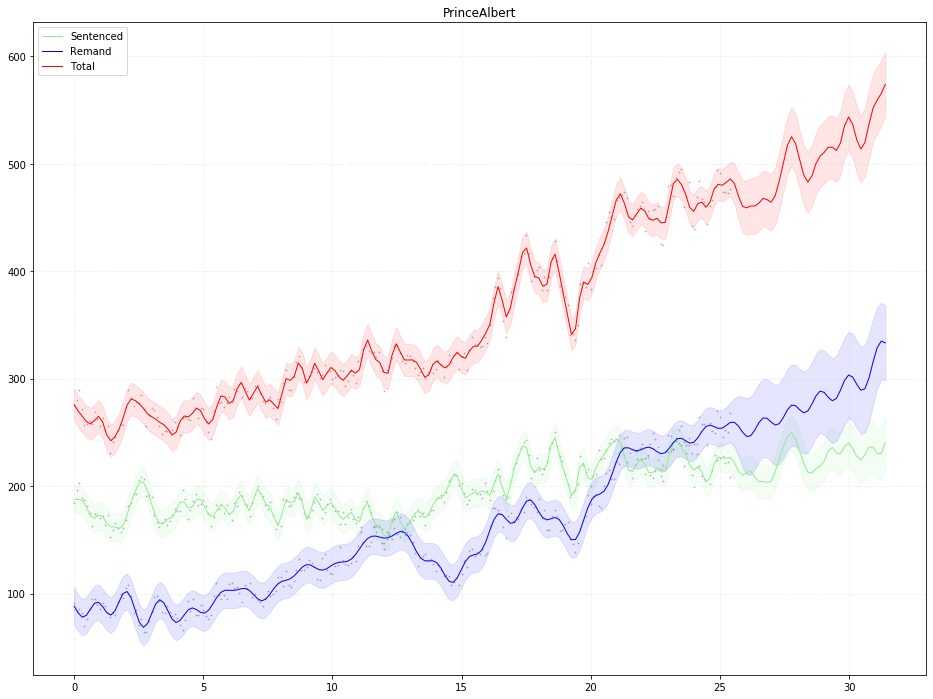

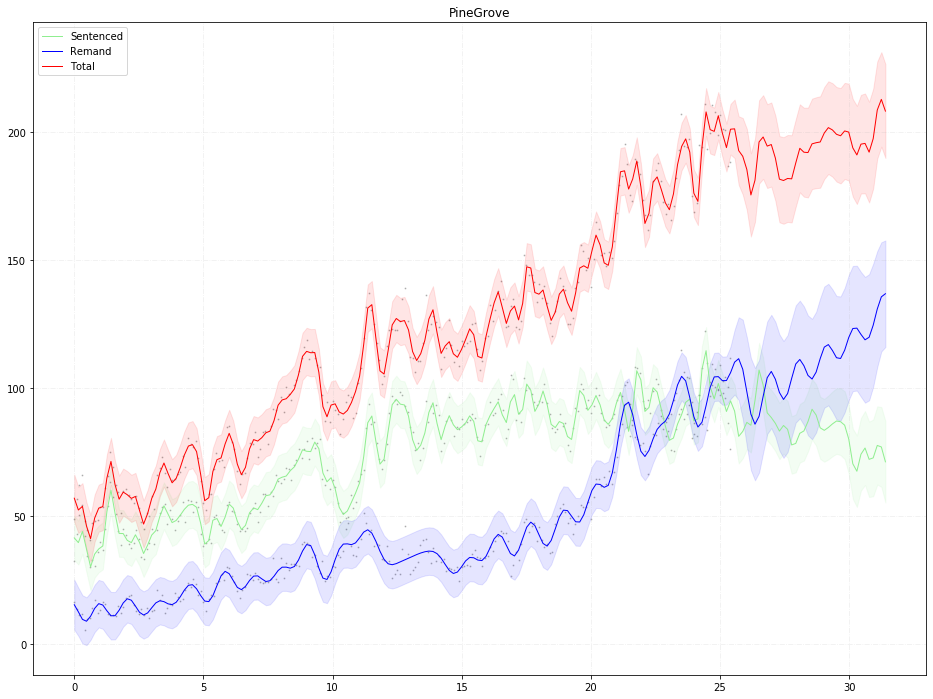

In [11]:
for cntr in centers:
    plot_population(df, center=cntr, start=0., yrs=yrs, method='monthly')


# Weighted Plots

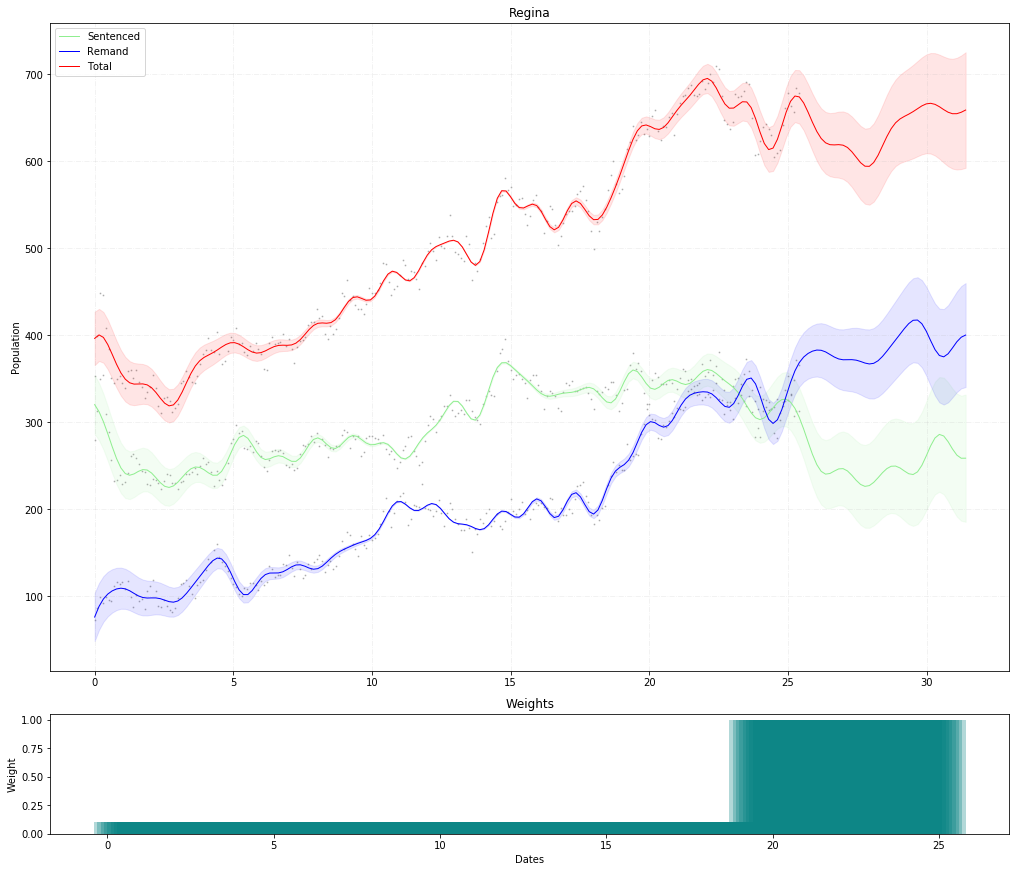

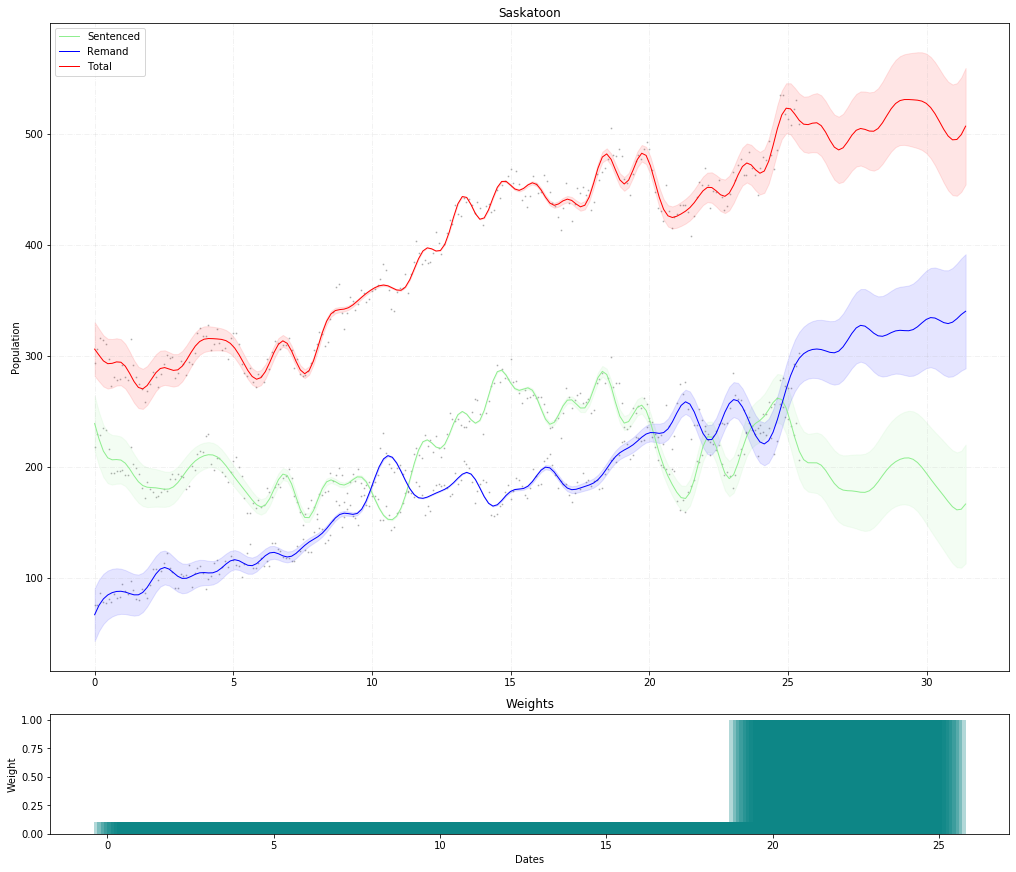

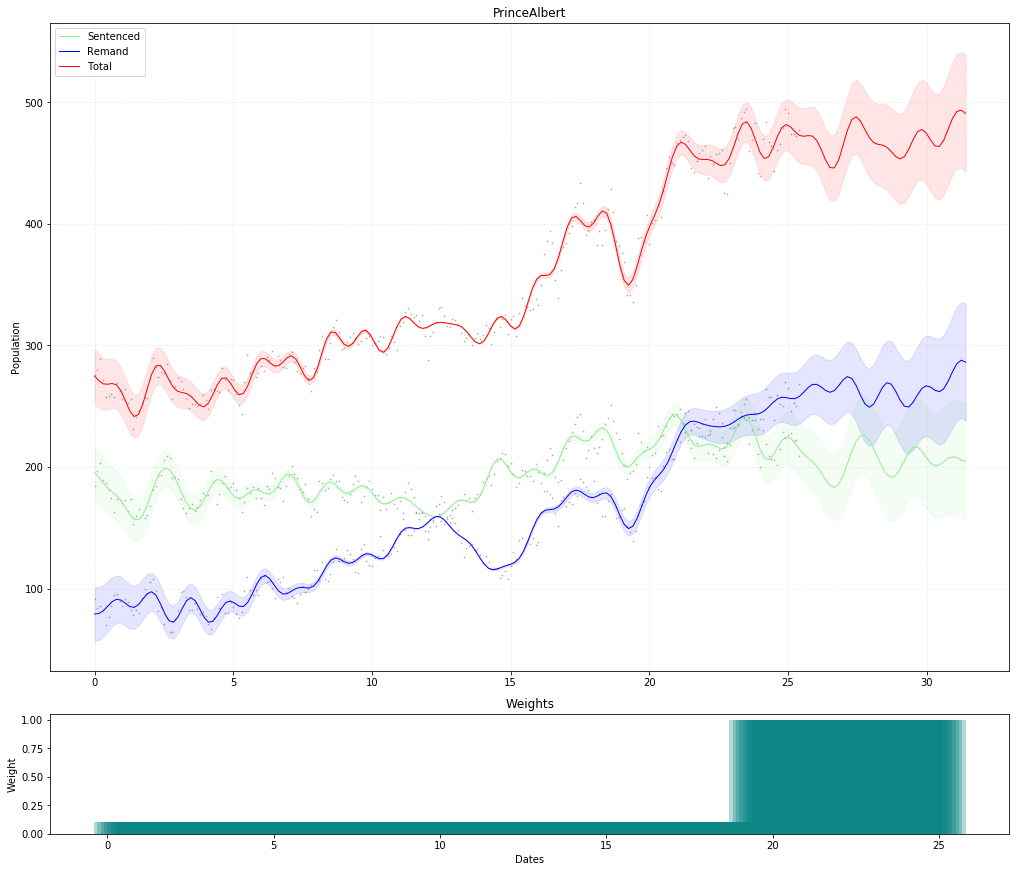

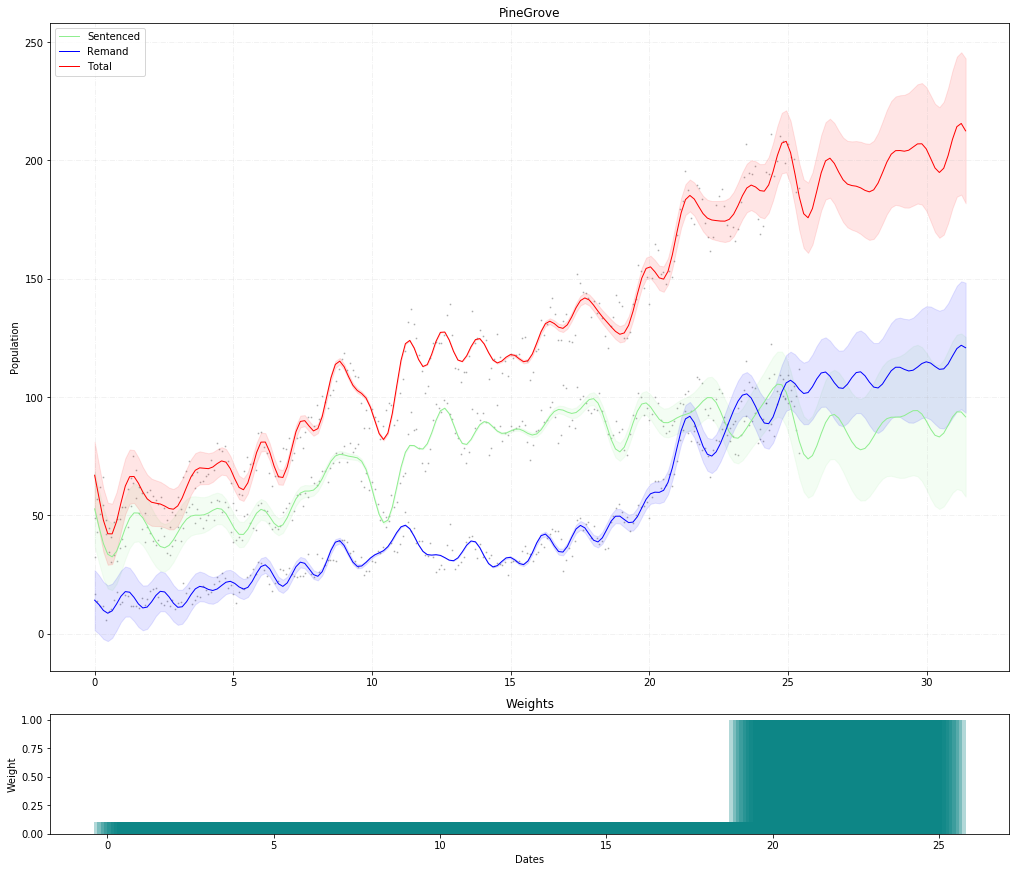

In [4]:
for cntr in centers:
    plot_population_hilbert(df, center=cntr, start=0., yrs=yrs, method='monthly')


# Facebook-Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
/home/mehdi/.local/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality

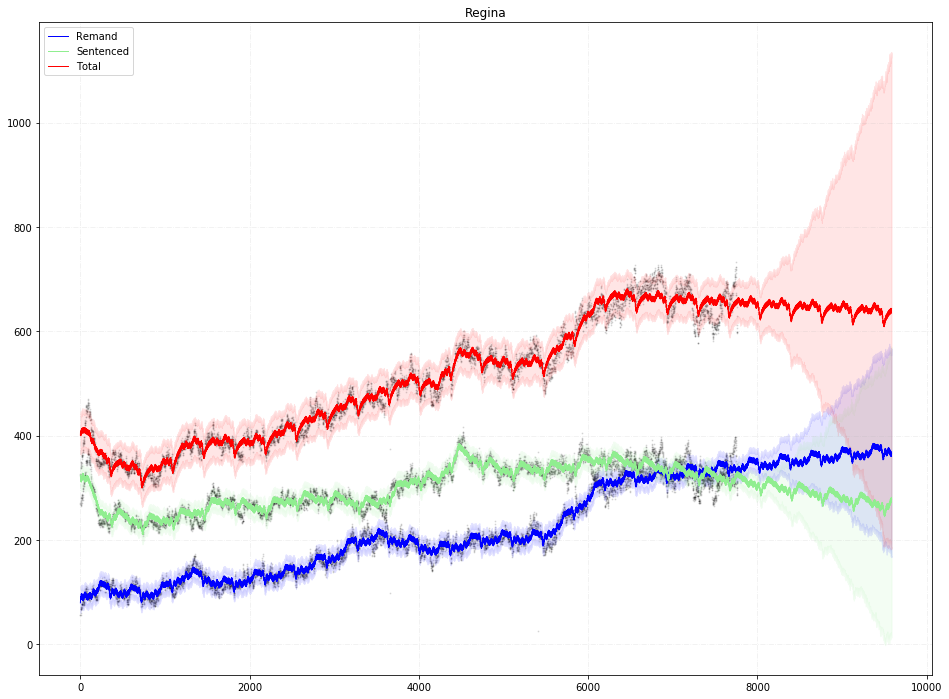

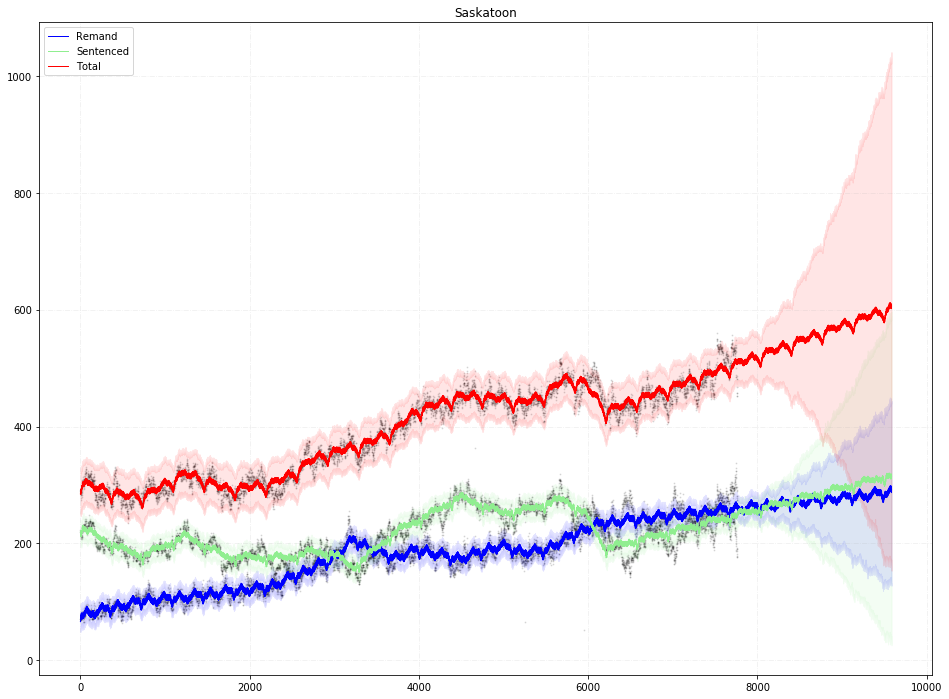

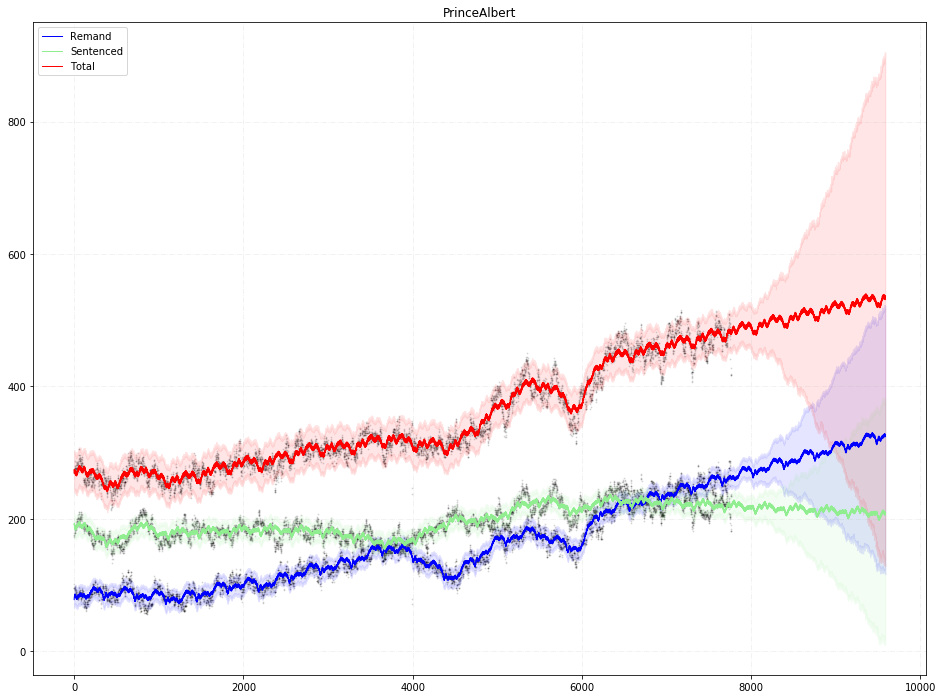

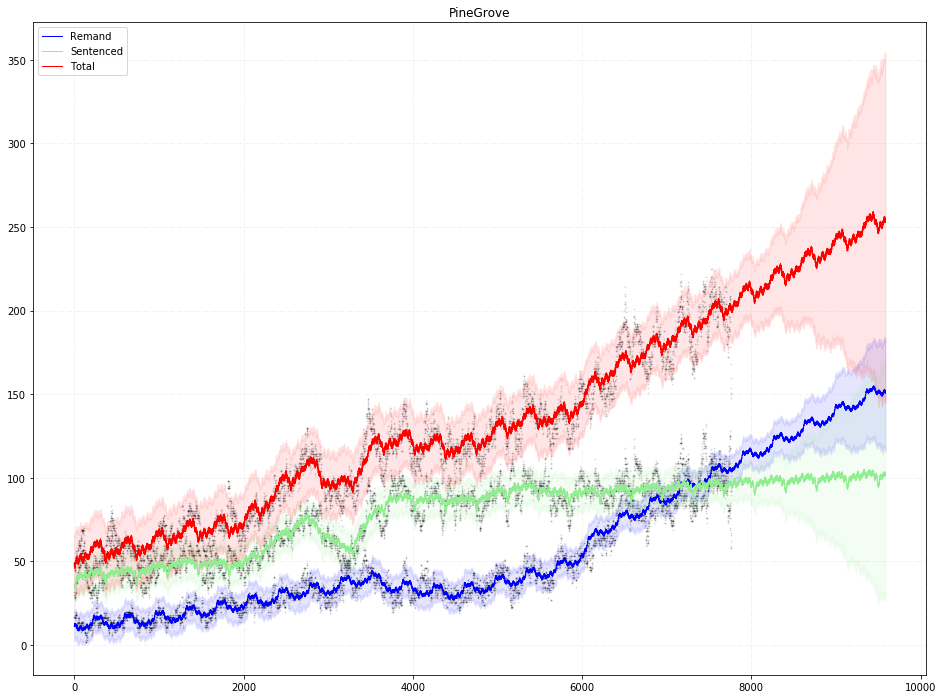

In [5]:
for cntr in centers:
    prophet(df, center=cntr, yrs=yrs)

# Growth rates

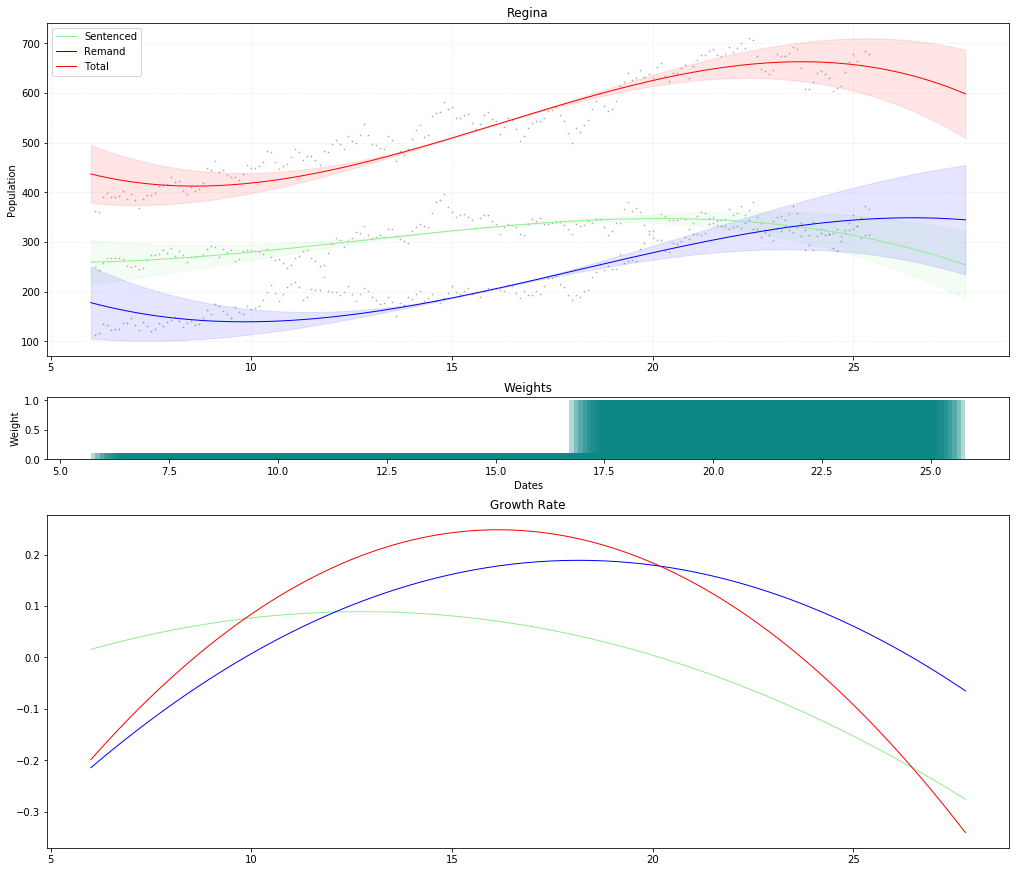

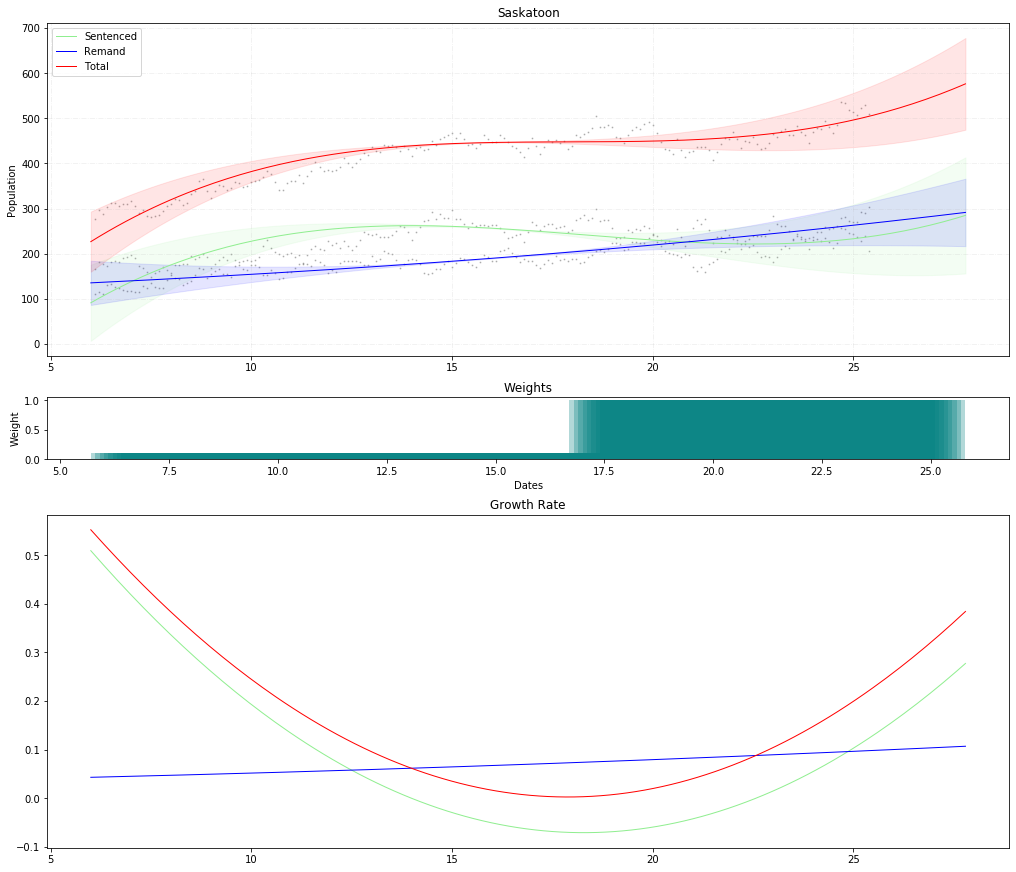

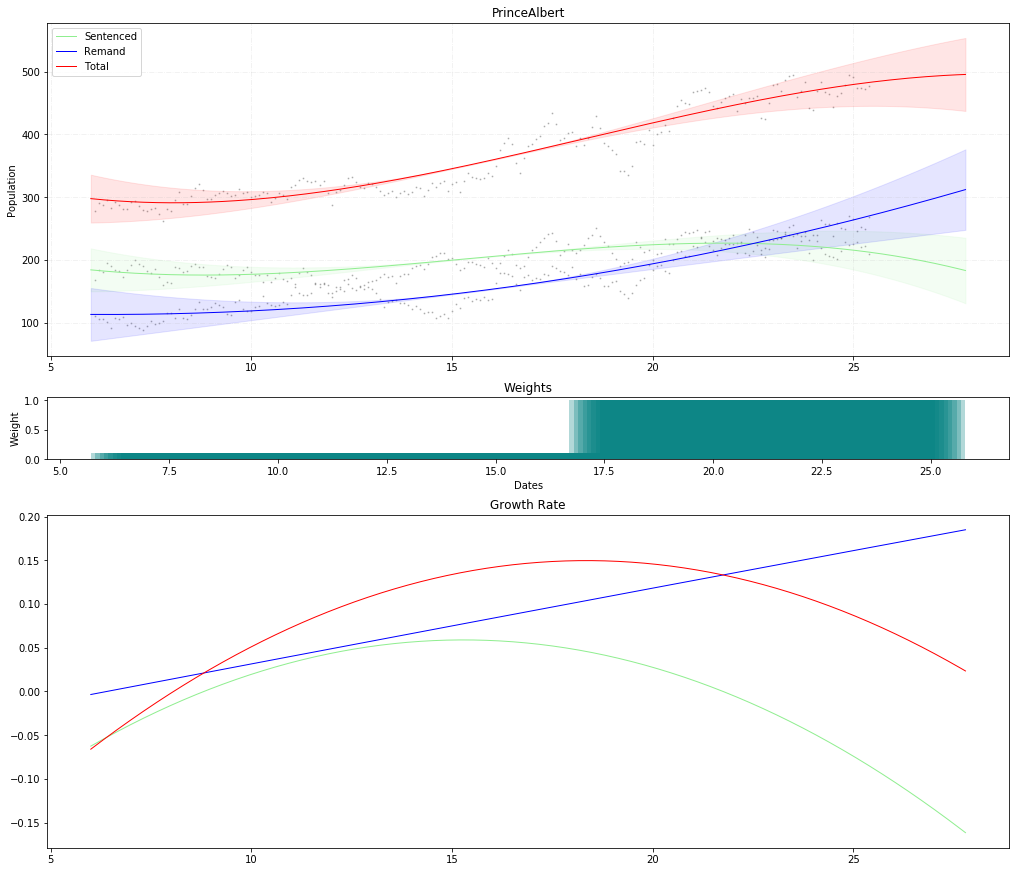

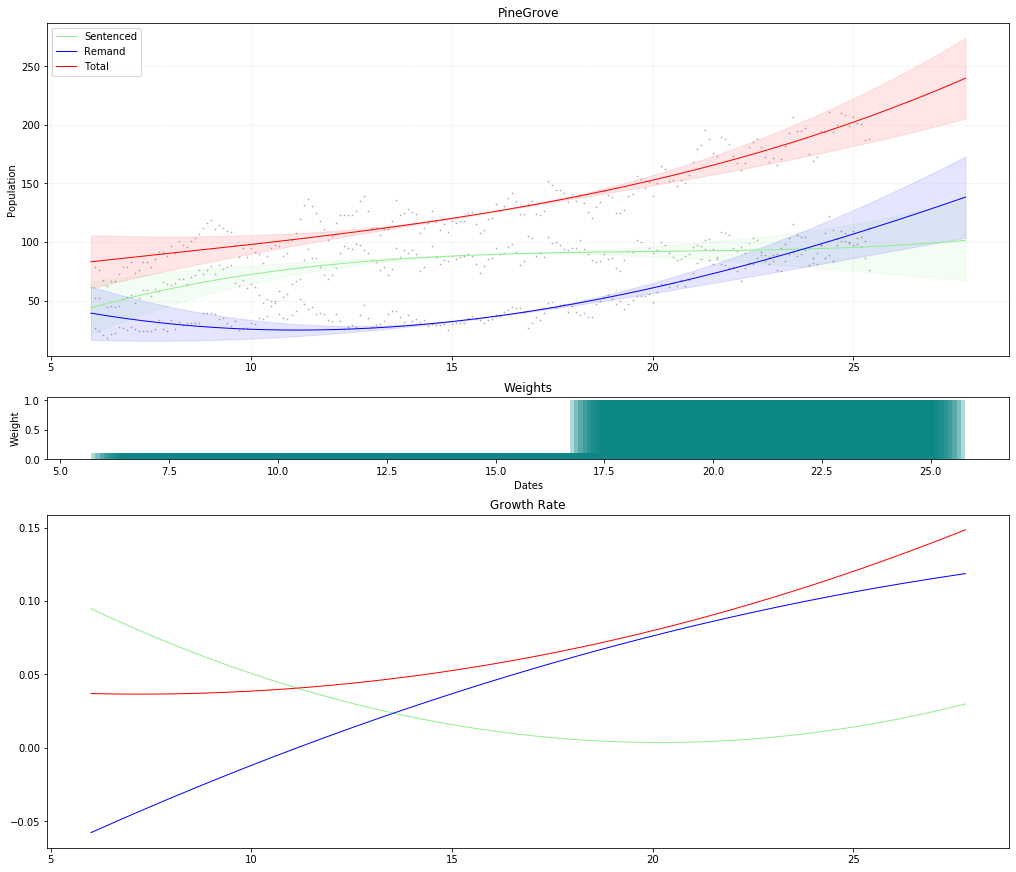

In [3]:
for cntr in centers:
    plot_population_baseline(df, center=cntr, start=6., yrs=2, method='monthly')


Case 3
Case 3
[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

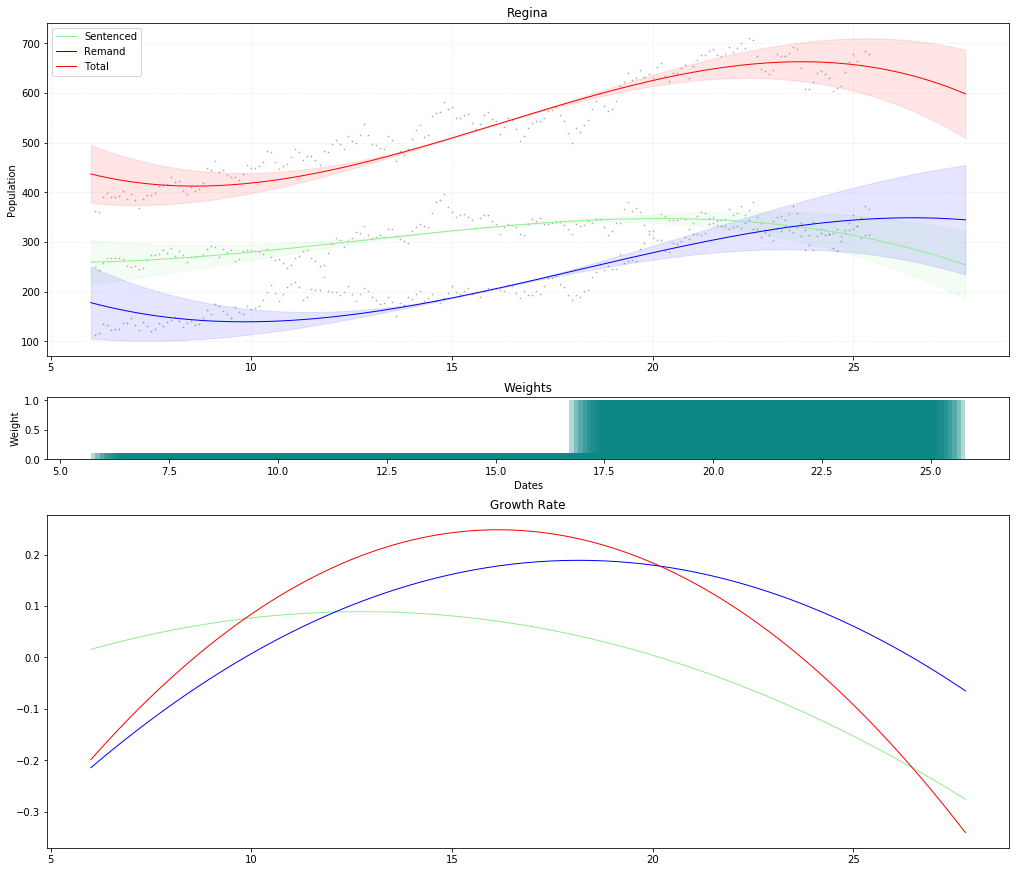

In [4]:
plot_population_baseline(df, center="Regina", start=6., yrs=2, method='monthly')

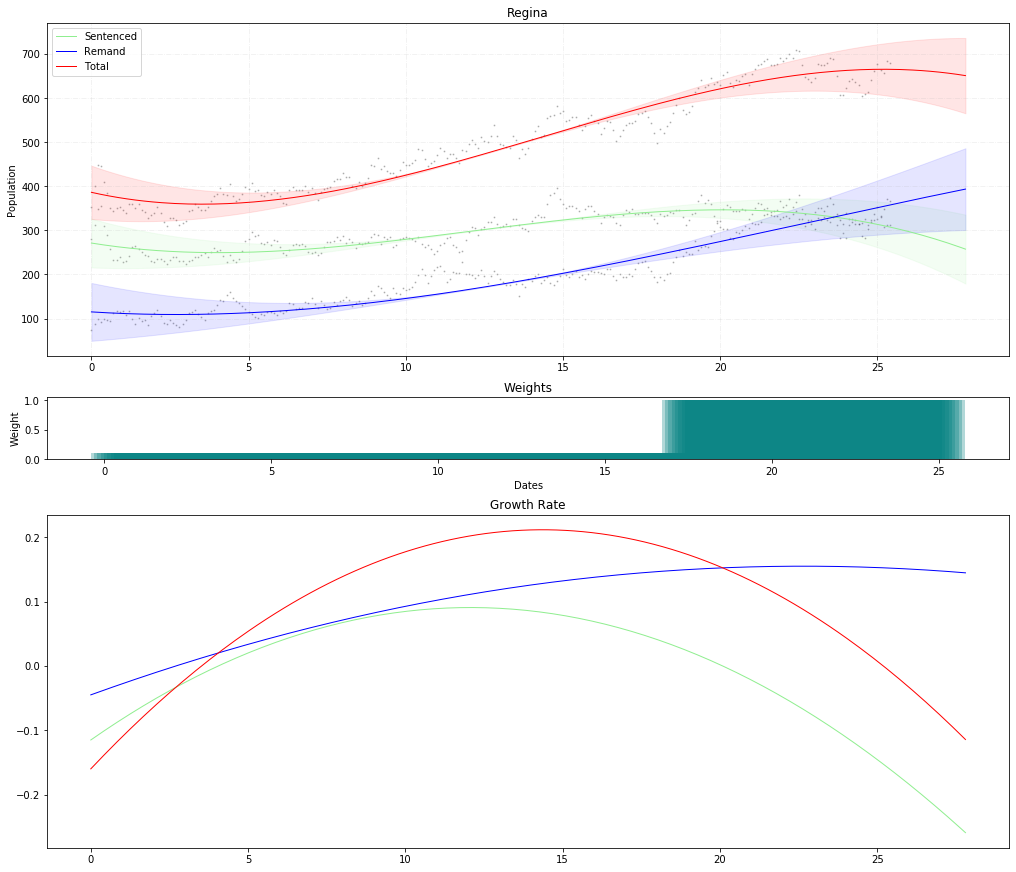

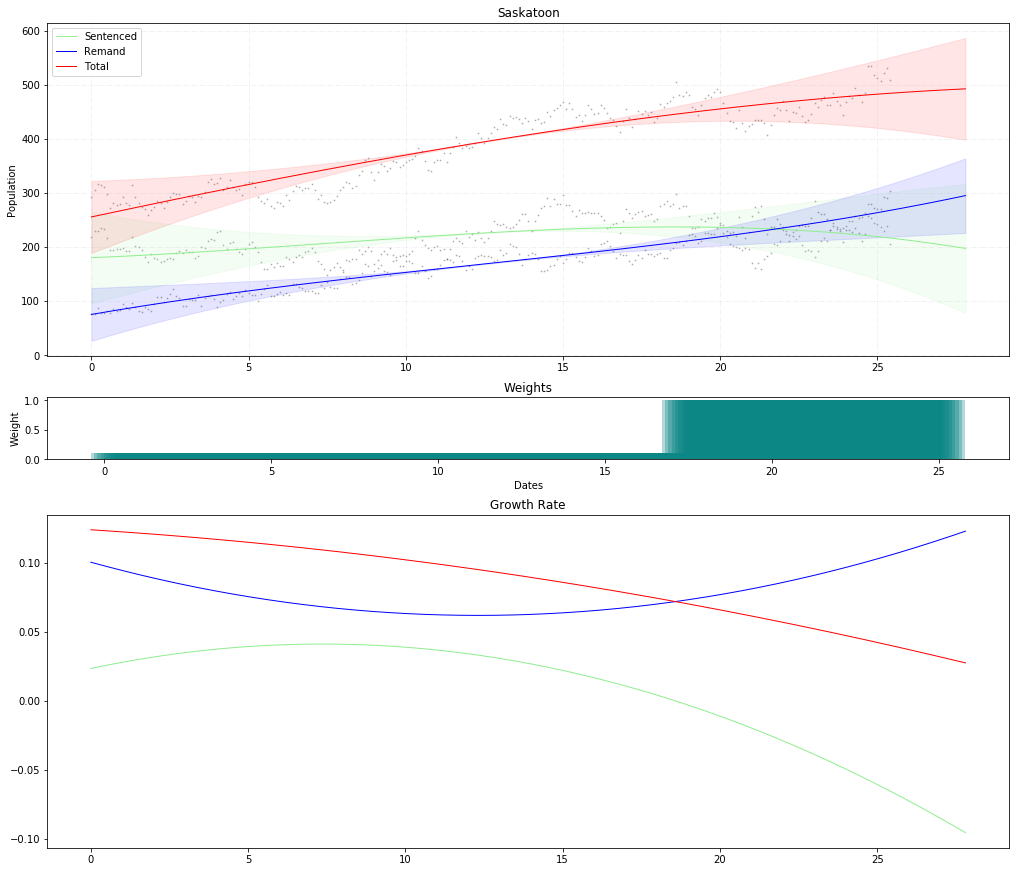

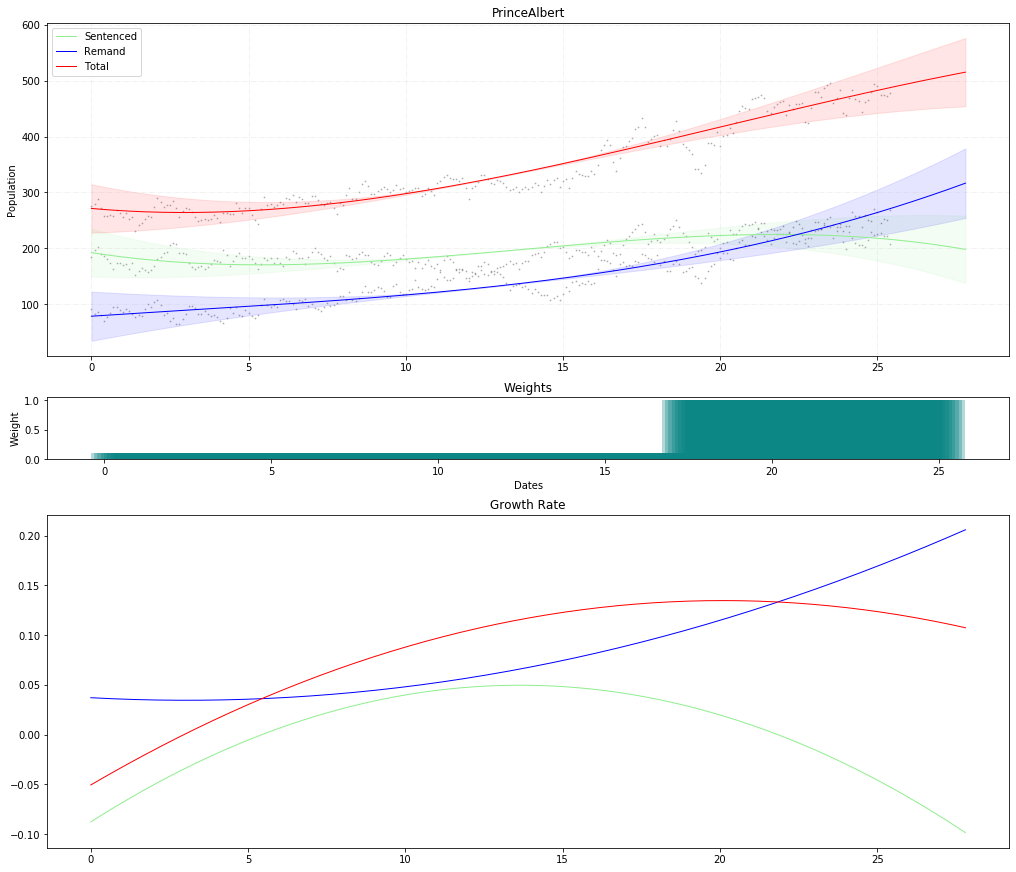

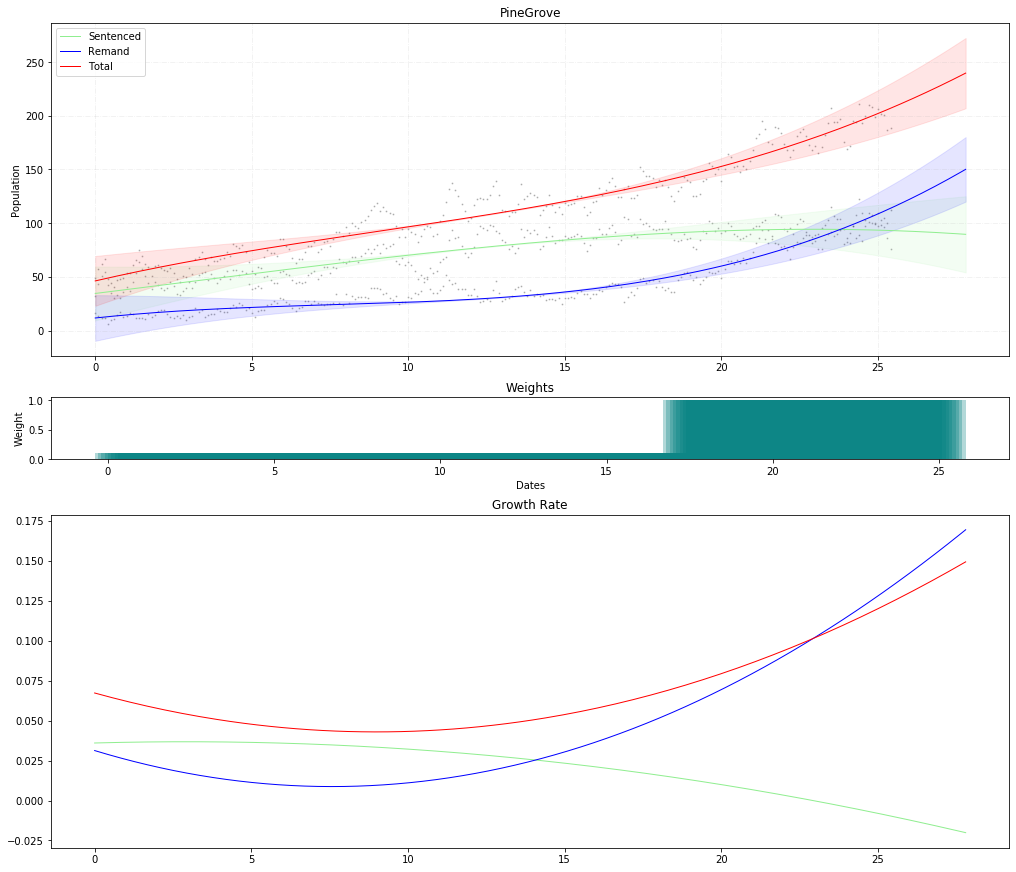

In [28]:
for cntr in centers:
    plot_population_baseline(df, center=cntr, start=0., yrs=2, method='monthly')


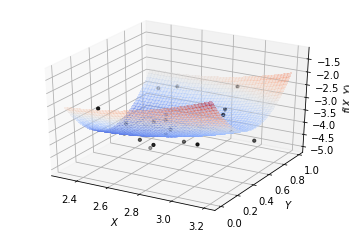

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from GeneralRegression.NpyProximation import HilbertRegressor, Measure
from GeneralRegression.extras import FunctionBasis
def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

# degree of polynomials
deg = 2
FB = FunctionBasis()
B = FB.poly(2, deg)
# initiate regressor
regressor = HilbertRegressor(base=B)
# number of random points
n = 20
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, m, zlow, zhigh in [('k', 'o', -5, -2.5)]:
    xs = randrange(n, 2.3, 3.2)
    ys = randrange(n, 0, 1.0)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, s=10, marker=m)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$f(X,Y)$')
X = np.array([np.array((xs[_], ys[_])) for _ in range(n)])
y = np.array([np.array((zs[_],)) for _ in range(n)])
X_ = np.arange(2.3, 3.2, 0.02)
Y_ = np.arange(0, 1.0, 0.02)
_X, _Y = np.meshgrid(X_, Y_)
# fit the regressor
regressor.fit(X, y)
# prepare the plot
Z = []
for idx in range(_X.shape[0]):
    _X_ = _X[idx]
    _Y_ = _Y[idx]
    _Z_ = []
    for jdx in range(_X.shape[1]):
        t = np.array([np.array([_X_[jdx], _Y_[jdx]])])
        _Z_.append(regressor.predict(t)[0])
    Z.append(np.array(_Z_))
Z = np.array(Z)
surf = ax.plot_surface(_X, _Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=.3)


In [3]:
regressor.score(X, y)

0.20538490757863787